In [23]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image

- docs: https://www.tensorflow.org/api_docs/python/tf/WholeFileReader

In [24]:
# 현재 디렉토리를 이용해서 파일 이름을 확인한다.
# for dir in os.listdir(os.getcwd()):
#     print dir

In [25]:
image_path1 = os.getcwd() + '/image.png'
image_path2 = os.getcwd() + '/image-grayscaled.png'
filename_list = [image_path1, image_path2]
filename_queue = tf.train.string_input_producer(filename_list)

In [26]:
reader = tf.WholeFileReader()

key, value = reader.read(filename_queue)

print key
print value

Tensor("ReaderReadV2_2:0", shape=(), dtype=string)
Tensor("ReaderReadV2_2:1", shape=(), dtype=string)


- Encoding and Decoding : https://www.tensorflow.org/api_guides/python/image

In [27]:
images = tf.image.decode_png( value )
images_resized = tf.image.resize_images(images_decoded, [360, 360])

In [0]:
image_width = 721
image_height = 720

In [60]:
x = tf.placeholder( tf.float32, [None, image_width, image_width, 3]  )
y_ = tf.placeholder( tf.float32, [None, 2] )

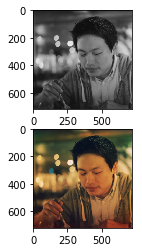

0
1


In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    thread = tf.train.start_queue_runners(sess, coord)

    fig = plt.figure()

    for i in range(len(filename_list)):
        image = sess.run( images )

        original = Image.fromarray(image)
        fig.add_subplot(2,1,i+1)
        imgplot = plt.imshow(np.asarray(original))

        print i 

    coord.request_stop()
    coord.join()

sess.close()

- 컴퓨터의 벡터 연산과 수학에서 표현하는 벡터간의 표현차이

In [29]:
import numpy as np

vector_in_computer = [[1,2,3,4,5], [6,7,8,9,10]]
print vector_in_computer
print np.shape(vector_in_computer)

vector_in_math = [[1], [2], [3], [4], [5]]
print vector_in_math
print np.shape(vector_in_math)


[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]
(2, 5)
[[1], [2], [3], [4], [5]]
(5, 1)
